# Projet Datascientest | DST_DEC22 | Rapport de modélisation

**Participants** : Olga TOLSTOLUTSKA, Mohamed BACHKAT, Charly LAGRESLE \
**Mentor** : Manu PORTEL \
**Date du document** : 2023/02/20

## Contexte et objectif

Rakuten est un site de e-commerce, regroupant près de 1.3 milliards d'utilisateurs. Afin de faciliter la gestion des suggestions de leurs recherches ou des recommandations qui leurs seront proposées, il est important de classifier les produits. Du fait de la quantité de produits et de leurs catégories associées, ce classement ne peut ni être fait manuellement, ni être régi par des règles. Une approche plus flexible, efficace et reproductible est donc à mettre en place. 

L'objectif est de prédire le code de chaque produit, c'est-à-dire sa catégorie, sur la base d'une analyse de données textuelles et d'images.



## Prérequis

### Equilibrage : 

Nous avions la possibilité d'effetuer un rééquilibrage du dataset, via notamment des méthodes telles que l'oversampling ou l'undersampling. Ce choix n'a pas été fait, afin de conserver la pureté du dataset fourni.

Nous chercherons donc à étudier les métriques non faussées par le déséquilibrage du dataset fourni.

### Choix des métriques

Plusieurs possibilités sont ici aussi à notre disposition. Au sein des réseaux de neurones, le suivi de leurs performances est effectué sur la métrique *SparseCategoricalAccuracy*. Nous disposons également d'une métrique appelée *BalancedSparseCategoricalAccuracy*.

Pour classer les différents réseaux entre eux, nous avons choisi d'utiliser le *classification_report_imbalanced* qui prend en charge le déséquilibre des données avant de renvoyer ses métriques.

Pour rappel, 27 catégories sont à notre disposition. Cela signifie qu'un score de plus de 3.7% est d'ores et déjà supérieur à un modèle purement aléatoire.

Nous avons fait face à beaucoup d'*overfitting*. Pour tous les modèles, une CrossValidation à 3 échantillons a été effetuée en prévention.



## Modèles simples de machine learning

### Texte

Comme l'expliquait le rapport d'exploration, les données textuelles sont très hétéorgènes :
* la longueur des textes est varie de 0 à plusieurs milliers de mots dans les colonnes *description* et *designation*
* la colonne *description* comprend de nombreuses valeurs manquantes

Nous choisissons donc de merger les colonnes *designation* et *description* pour ne se concentrer que sur cette nouvelle colonne *text*.

Sur celle-ci, un travail de nettoyage est effectué : suppression des mots d'arrêt, des caractères speciaux, mise en minuscule, stemmatisation.

Pour accélérer les algorithmes et en se basant sur notre analyse exploratoire,  les textes ont été rognés aux 500 premiers mots.


#### Modèles testés

Plusieurs modèles ont été mis en place. Les modèles sont ici utilisés dans leur configuration par défaut, c'est-à-dire sans hyperparamètres. Les scores mentionnés sont issus du rapport de classification déséquilibré. 

| Modèle                | Type     | Accuracy | Recall | F1-Score | Durée de l'entrainement |
|-----------------------|----------|-----------|--------|----------|-------------------------|
| DecisionTree         | Simple   | 0.60 | 0.63 | 0.61 | 47s |
| KNC                  | Simple   | 0.49 | 0.46 | 0.46 | 28s |
| RandomForest         | Ensemble | 0.69 | 0.69 | 0.69 | 94s |
| GradientBoosting     | Ensemble | 0.62 | 0.56 | 0.56 | 2497s |
| AdaBoost             | Ensemble | 0.31 | 0.32 | 0.27 | 148s |


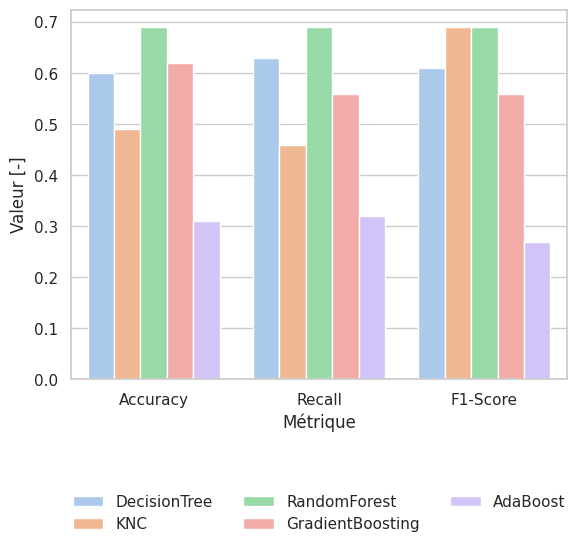

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

sns.set_theme(style="whitegrid", palette="pastel")

df = pd.DataFrame.from_dict(
    {"Modèle" : ["DecisionTree", "KNC", "RandomForest", "GradientBoosting", "AdaBoost"],
    "Accuracy" : [.60, .49, .69, .62, .31],
    "Recall" : [.63, .46, .69, .56, .32],
    "F1-Score" : [.61, .69, .69, .56, .27],
    #"Duration" : [257, 171, 0, 141, 94, 2497, 148],
    }
)
df_melted = df.melt(id_vars="Modèle", value_vars=["Accuracy", "Recall", "F1-Score"], value_name="Valeur [-]", var_name="Métrique")
sns.barplot(data=df_melted, x="Métrique", y="Valeur [-]", hue="Modèle");
plt.legend(loc='lower center', frameon=False, bbox_to_anchor=(0.5, -.45), ncol=len(df_melted.columns));

Les scores obtenus par les modèles de *machine learning* sont au-delà d'un modèle purement aléatoire. L'utilisation de métriques propres à gérer des jeux de données déséquilibrés nous permet d'obtenir des scores de *precision* et de *recall* proches.

Le modèle *RandomForest* est le plus performant dans sa configuration d'origine avec un score de 69%.

<img src="../src/models/text/random_forest/crosstab.jpg" width="500" height="400">

NOTE : si le temps nous le permet, une étude GridSearchCV sera effectuée affin de déterminer les hyperparamètres les plus performants de chaque modèle.


### Image

#### Mise en place des données

Les images sont importées via un ImageDataGenerator afin de :
* ne pas les charger directement en mémoire
* appliquer un redimensionnement 
* appliquer des transformations aléatoires

/!\PAS DE SUITE, c'est du finetuning, endommage les inputs/!\

Question : faire un zoom fixe?


#### Modèles testés

**CNN Simple** 

| Layer (type)       | Output Shape | Param |  
|--------------------|--------------|-------|
|Conv2D              |(None, 100, 100, 64) |     1792 |
|MaxPooling2D        |(None, 34, 34, 64)   |     0    |
|Dropout             |(None, 34, 34, 64)   |     0    |
|Flatten             |(None, 73984)        |     0    |
|Dense               |(None, 27)           |     1997595    |


Total params: 1,999,387 \
Trainable params: 1,999,387 \
Non-trainable params: 0


| Modèle                | Type     | Accuracy | Recall | F1-Score | Durée de l'entrainement |
|-----------------------|----------|-----------|--------|----------|-------------------------|
| CNN Simple    | CNN   | 0.66 | 0.70 | 0.67 | 169s |

ATTENTION
val_accuracy ~ 0.4
test_accuracy ~ 

## Modèles de *deep learning*

### Texte

L'extraction des données est faite sur la colonne *text* résultant de la fusion des deux colonnes descriptives du produit. 

* Modèles
    * Neural_Simple : modèle simple à couches denses se basant sur la sortie numérique de notre vectorisation TFIDF
    * Neural_Embedder : modèle similaire à *Neural_Simple* mais où la première couche est une couche d'*embedding*. 
    
Le modèle *Neural_Embedder*, a la particularité de présenter une couche d'embedding qui nous permet de fournir directement un ensemble de mots à ce réseau de neurones. La vectorisation pour ce réseau gère 50 000 mots et seuls les 500 plus fréquents sont conservés. 


Organisation des couches du réseau de neurones *Neural_Embedder*

| Layer (type)       | Output Shape | Param |  
|--------------------|--------------|-------|
|text_input (Embedding)      (None, 500, 32)           1600000   
|text_conv_1 (Conv1D)        (None, 494, 32)           7200      
|text_max_1 (MaxPooling1D)   (None, 98, 32)            0         
|text_conv_2 (Conv1D)        (None, 92, 32)            7200      
|text_glob_1 (GlobalMaxPooling1D)  (None, 32)        0    0                                                                   
|text_drop_2 (Dropout)       (None, 32)                0         
|text_output (Dense)         (None, 27)                891



| Modèle   |  Accuracy | Recall | F1-Score | Durée de l'entrainement |
|----------|-----------|--------|----------|-------------------------|
| NN 1     | .77   | .76 | 0.76 | 254s |


## Fusion des modèles

Nous disposons à présent de deux modèles, l'un pour prédire les catégories à partir du texte, l'autre à partir des images. Il s'agit maintenant d'exploiter ces deux modèles ensemble.

Deux solutions s'offrent à nous : 
* utiliser les prédictions des modèles 
* utiliser les couches des modèles

REMARQUE : cette partie sera complétée par la suite, les sorties du modèle relatif aux images ne nous permettant pas encore d'exploiter pleinement la fusion.

### Fusion simple

### Fusion par concaténation des couches

La fusion des modèles est effectuée grâce à la concaténation de l'avant-dernière couche de chaque modèle. Pour ne pas entrainer à nouveau la totalité des deux modèles, les couches précédents la concaténation sont *freezées*.




Le modèle de 
* Même produits entrainement
* Pas les mêmes features

Methodes à notre disposition :
* Voting
* Stacking
* MultiInput
* Concatenation de la couche precendent la couche à 27 couches
* Entrainer juste les couches de derniere classification

* Rapport
* Summary
* RNN : a faire
* VGG16 transfert leaning, VGG16 penser à redimensionner les images
* FUSION
* Pousser master
* 15h demain

